**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [17]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import get_dataset_config_names
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**The Dataset**
- We will use **SubjQA** dataset which consists of more than 10,000 customer reviews in English about products and services.

In [5]:
#@ LOADING THE DATASET:
domains = get_dataset_config_names("subjqa")                # Getting domain names. 
domains                                                     # Inspection.

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [7]:
#@ LOADING THE DATASET:
subjqa = load_dataset("subjqa", name="electronics")         # Initializing electronics qa. 
print(subjqa["train"]["answers"][1])                        # Inspecting answers.

Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [8]:
#@ INSPECTING THE DATASET:
dfs = {split: dset.to_pandas() for split,dset in subjqa.flatten().items()}  # Initialization.
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")          # Inspecton.

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [9]:
#@ PREPARING THE DATASET: 
qa_cols = ["title", "question", "answers.text", "answers.answer_start", 
           "context"]                                                       # Initialization.
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)                 # Initializing sample dataframe. 
sample_df                                                                   # Inspecting dataframe.

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [10]:
#@ INSPECTING THE ANSWER:
start_index = sample_df["answers.answer_start"].iloc[0][0]                  # Initializing starting index.
end_index = start_index + len(sample_df["answers.text"].iloc[0][0])         # Initializing ending index.
sample_df["context"].iloc[0][start_index:end_index]                         # Inspecting answer.

'this keyboard is compact'

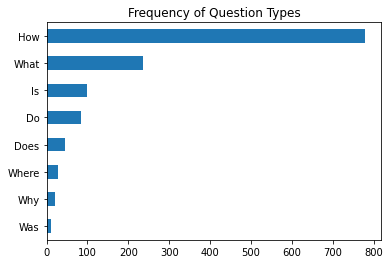

In [11]:
#@ INSPECTING THE QUESTION:
counts = {}                                                                       # Initialization.
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where","Why"]        # Initializing question words.
for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]   # Initializing value counts.
pd.Series(counts).sort_values().plot.barh()                                       # Creating plots.
plt.title("Frequency of Question Types")                                          # Initialization.
plt.show()                                                                        # Inspection. 

In [12]:
#@ INSPECTING QUESTIONS WITH START WORDS: 
for question_type in ["How", "What", "Is"]:
    for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)]
                     .sample(n=3, random_state=2022)["question"]):
        print(question)

How are the bass?
How is the camera?
How is the speed?
What is the quality of the customer service?
What do you think about detail?
What is amount?
Is the option available?
Is the hole big or small?
Is this how zoom works?


**Extracting Answers**

In [15]:
#@ TOKENIZING TEXT FOR QUESTION ANSWERING: SAMPLE EXAMPLE:
model_ckpt = "deepset/minilm-uncased-squad2"                        # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)               # Initializing pretrained tokenizer.
question = "How much music can this hold?"                          # Initializing question.
context = "An MP3 is about 1 MB/minute, so about 6000 hours \
           depending on file size."                                 # Initializing context.
inputs = tokenizer(question, context, return_tensors="pt")          # Initializing input tensors.
print(tokenizer.decode(inputs["input_ids"][0]))                     # Decoding IDs. 

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


**Training Model**

In [19]:
#@ TRAINING THE QA MODEL:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)   # Initializing pretrained model.
with torch.no_grad():                                               # Clearing gradients.
    outputs = model(**inputs)                                       # Implementation of model.
print(outputs)                                                      # Inspection.

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)
